In [1]:
%pylab inline
import scipy.integrate as spi
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Taller 2

## Jaime Andres Moreno Ramos
## 201415848

# Caracterización del Kart

In [116]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)
mr=((2*illd+2*illt+ig)+ii*(ng**2))/(refc**2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq = 200 # ESto toca calcularlo correctamente

gamma = 1 # aceleracion

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*cos(theta) # (N)

def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return w*fr*cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

def torquemotor_curva(vx):
    omega=((vx*ng)/refc)*(60/(2*pi))
    if(omega>5000):
        omega=5000
    P=((-0.00000004564538677*omega**3)+(0.0001056995459*omega**2)+(1.53209191*omega)-1.895523696)
    T=P/(omega*2*pi/60)
    if (T>5.42):
        T= 5.42
    return T
#Caracterizacion para aceleracion
def dveldt(velv,t0,ng_0,masa_0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,(torquemotor_curva(vel)*ng_0*etaf/refc-frod-farr-fincli)/(masa_0+mr)]
    
#Caracterizacion para freno
def dveldt_freno(velv,t0,ng_0,masa_0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    torque_frenado=-18
    return [vel,(torque_frenado*ng_0*etaf/refc-frod-farr-fincli)/(masa_0+mr)]

# Aceleración

En esta sección se realiza la predicción de la aceleración para el kart eléctrico de la Universidad de los Andes, en esta ocasión bajo los parámetros establecidos por los trabajos previos de los Ingenieros Clavijo y Cordoba. Para esto se resuelve la integración de una ecuación diferencial que describe el comportamiento de las fuerzas lineales del Kart, bajo unos parametros de tiempo y la caracterización del motor del vehiculo. De este modo se obtiene la velocidad y la distancia recorrida por el Kart.

In [58]:
# Variables de tiempo
t_in=0
t_fin=120
deltat=0.0001

# condiciones iniciales
x_0=0.1
v_0=0.1
c_ini = [x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

In [64]:
sol = spi.odeint(dveldt, c_ini, t, args=(ng,masa))

In [65]:
vel_m=sol[1000000]
vel_max=vel_m[1]

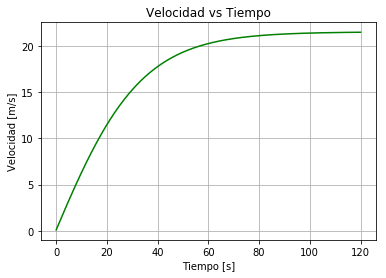

In [134]:
plt.plot(t, sol[:, 1], 'g')
plt.title('Velocidad vs Tiempo')
plt.ylabel('Velocidad [m/s]')
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

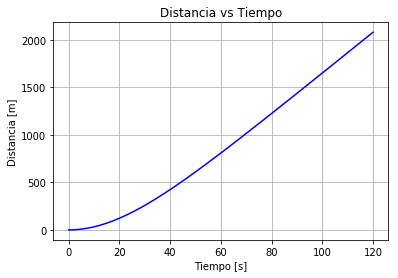

In [130]:
plt.plot(t, sol[:, 0], 'b')
plt.title('Distancia vs Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Distancia [m]')
plt.grid()
plt.show()

# Frenado

En el caso de frenado se resuelve nuevamente la ecuación diferencial, por supuesto en este caso las condiciones iniciales cambian y dependen de los parametros de velocidad finales de la sección Aceleración.

In [136]:
# Variables de tiempo de frenado
t_in_f=0
t_fin_f=8
deltat_f=0.0001

# condiciones iniciales frenado
x_0=0.1
ve_max=vel_max
c_ini_freno = [x_0,v_max]
t_freno=np.arange(t_in_f,t_fin_f,deltat_f)

In [137]:
sol_freno = spi.odeint(dveldt_freno, c_ini_freno, t_freno,args=(ng,masa))

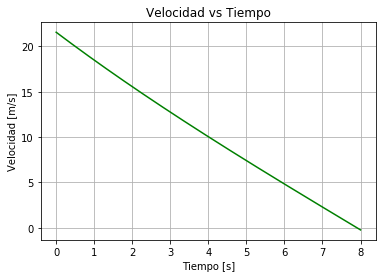

In [138]:
plt.plot(t_freno, sol_freno[:, 1], 'g')
plt.title('Velocidad vs Tiempo')
plt.ylabel('Velocidad [m/s]')
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

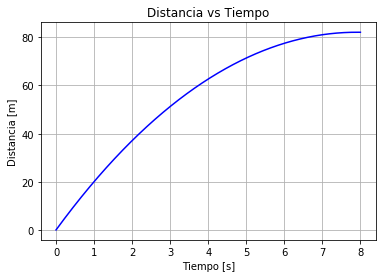

In [129]:
plt.plot(t_freno, sol_freno[:, 0], 'b')
plt.title('Distancia vs Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Distancia [m]')
plt.grid()
plt.show()

# Aceleración y freno desde 0

En este caso se realiza un modelo que permite estimar el tiempo y distancia recorrida en un proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero. Para esto se diseño un método en el cual se encuentra el máximo por medio de una diferencia entre un dato y su inferior, una vez hallado se detiene el tiempo en este punto y se inicia el proceso de frenado hasta una velocidad de 0. Para esto se resuelve la integración de las ecuaciones diferenciales tanto para aceleración como frenado. A partir de este modelo se obtienen las gráficas de velocidad y distancia como función del tiempo. 

En este caso se varían los parámetros con el fin de evaluar diferentes configuraciones del kart. En esta ocasión se varía la masa del vehículo así como su relación de transmisión, los cuales son: 
- Relación de transmisión:[3.54, 3, 2.5, 2]
- Masa: [138, 152, 165] kg

In [144]:
#Funcion que combina la aceleración y el freno del kart
def total(velx,frx,ng_0,masa_0):
    #Primero se resuelve la odeint para la aceleración
    t_ini = 0  
    t_fin=200
    deltat=0.001
    t_a = np.arange(t_ini,t_fin,deltat) 
    sol_ax = spi.odeint(velx, c_ini, t_a, args=(ng_0,masa_0)) 
    vel = sol_ax[:,1]
    pos = sol_ax[:,0] 
    t_ai = t_fin
    i=0
    vmax=[]
    pos1=[]
    t1=[]
    #Se fija una diferencia en la cual se define la velocidad máxima
    while vel[i+1]-vel[i]>0.000008:
        t1.append(t_a[i])
        pos1.append(pos[i])
        vmax.append(vel[i])
        i=i+1
    
    acel = np.gradient(vmax)*100
    #Se definen las condiciones de frenado
    v_max = vmax[-1] 
    x_1 = pos1[-1] 
    c_fr = [x_1,v_max]
    t_a1 = t1[-1]
    t_a2 = t_a1 + 0.5 
    t_br = np.linspace(t_a1,t_a2,1000) 
    sol_br = spi.odeint(frx, c_fr, t_br,args=(ng_0,masa_0)) 
    v_br = sol_br[:,1]
    x_br = sol_br[:,0] 
    #Se fija un valor para el cual se deja de calcular el freno
    while v_br[-1] > 0.1: 
        t_a2 = t_a2 + 0.5 
        t_br = np.linspace(t_a1,t_a2,1000) 
        sol_br = spi.odeint(frx, c_fr, t_br, args=(ng_0,masa_0)) 
        v_br = sol_br[:,1] 
        x_br = sol_br[:,0] 
    acelbr =np.gradient(v_br)*100
    #Se combinan los los datos
    t = np.concatenate((t1,t_br))
    x = np.concatenate((pos1,x_br))
    v = np.concatenate((vmax,v_br))
    a = np.concatenate((acel,acelbr))
    return (t,x,v,a) 

In [145]:
#Se fijan las variables para diferentes parámetros del Kart
kart_1_1= total(dveldt,dveldt_freno,3.54,152)
kart_1_2= total(dveldt,dveldt_freno,3,152)
kart_1_3= total(dveldt,dveldt_freno,2.5,152)
kart_1_4= total(dveldt,dveldt_freno,2,152)
kart_2_1= total(dveldt,dveldt_freno,3.54,138)
kart_2_2= total(dveldt,dveldt_freno,3,138)
kart_2_3= total(dveldt,dveldt_freno,2.5,138)
kart_2_4= total(dveldt,dveldt_freno,2,138)
kart_3_1= total(dveldt,dveldt_freno,3.54,165)
kart_3_2= total(dveldt,dveldt_freno,3,165)
kart_3_3= total(dveldt,dveldt_freno,2.5,165)
kart_3_4= total(dveldt,dveldt_freno,2,165)

## Gráficas 

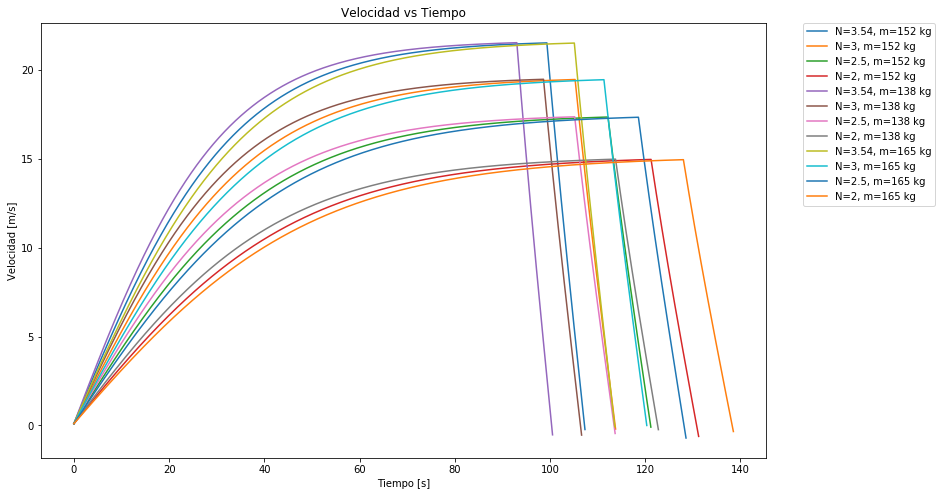

In [147]:
figure(figsize=(13,8))
#Primera Grafica
plt.plot(kart_1_1[0],kart_1_1[2],label='N=3.54, m=152 kg')
plt.plot(kart_1_2[0],kart_1_2[2],label='N=3, m=152 kg')
plt.plot(kart_1_3[0],kart_1_3[2],label='N=2.5, m=152 kg')
plt.plot(kart_1_4[0],kart_1_4[2],label='N=2, m=152 kg')
#Segunda Grafica
plt.plot(kart_2_1[0],kart_2_1[2],label='N=3.54, m=138 kg')
plt.plot(kart_2_2[0],kart_2_2[2],label='N=3, m=138 kg')
plt.plot(kart_2_3[0],kart_2_3[2],label='N=2.5, m=138 kg')
plt.plot(kart_2_4[0],kart_2_4[2],label='N=2, m=138 kg')
#Tercera Grafica
plt.plot(kart_3_1[0],kart_3_1[2],label='N=3.54, m=165 kg')
plt.plot(kart_3_2[0],kart_3_2[2],label='N=3, m=165 kg')
plt.plot(kart_3_3[0],kart_3_3[2],label='N=2.5, m=165 kg')
plt.plot(kart_3_4[0],kart_3_4[2],label='N=2, m=165 kg')

plt.title('Velocidad vs Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [m/s]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

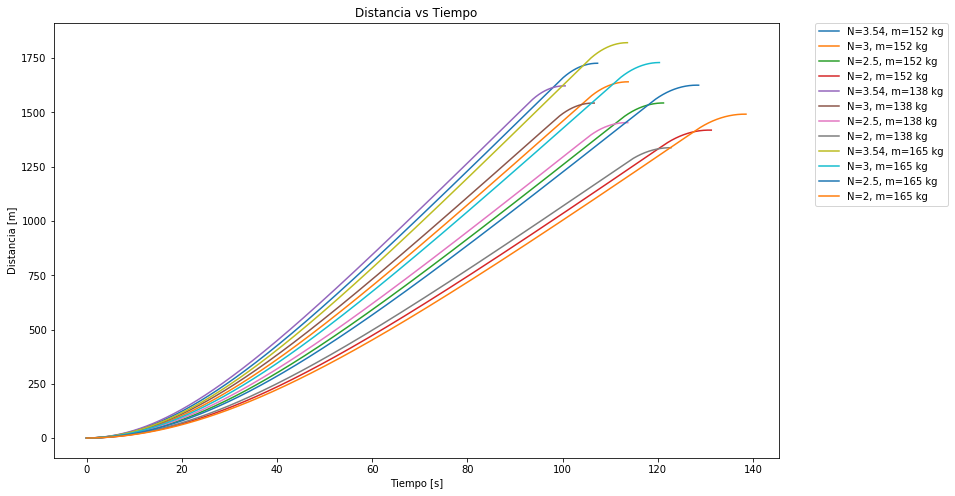

In [149]:
figure(figsize=(13,8))
#Primera Grafica
plt.plot(kart_1_1[0],kart_1_1[1],label='N=3.54, m=152 kg')
plt.plot(kart_1_2[0],kart_1_2[1],label='N=3, m=152 kg')
plt.plot(kart_1_3[0],kart_1_3[1],label='N=2.5, m=152 kg')
plt.plot(kart_1_4[0],kart_1_4[1],label='N=2, m=152 kg')
#Segunda Grafica
plt.plot(kart_2_1[0],kart_2_1[1],label='N=3.54, m=138 kg')
plt.plot(kart_2_2[0],kart_2_2[1],label='N=3, m=138 kg')
plt.plot(kart_2_3[0],kart_2_3[1],label='N=2.5, m=138 kg')
plt.plot(kart_2_4[0],kart_2_4[1],label='N=2, m=138 kg')
#Tercera Grafica
plt.plot(kart_3_1[0],kart_3_1[1],label='N=3.54, m=165 kg')
plt.plot(kart_3_2[0],kart_3_2[1],label='N=3, m=165 kg')
plt.plot(kart_3_3[0],kart_3_3[1],label='N=2.5, m=165 kg')
plt.plot(kart_3_4[0],kart_3_4[1],label='N=2, m=165 kg')

plt.title('Distancia vs Tiempo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Tiempo [s]')
plt.ylabel('Distancia [m]')
plt.show()

# Discusión de Resultados

## Velocidad vs. Tiempo
En la gráfica de Velocidad vs. Tiempo se puede observar que al disminuir la relación de transmisión para cada una de las diferentes masas del kart se disminuye la velocidad máxima del mismo y se aumenta el tiempo necesario para alcanzar dicha velocidad tope. El frenado por su parte responde de manera lineal a la velocidad máxima que se alcanza. 
Por otra parte se observa que el peso del kart influye en el tiempo en el cual se alcanza la velocidad máxima, es así que al disminuir el peso del kart, ya sea por medio de una redistribución de peso y uso de materiales livianos, un piloto liviano o ambos, se puede obtener un menor tiempo para alcanzar la velocidad máxima del kart. 

Es así que se convierte en una relación peso/transmisión para hacer óptimo el desempeño del vehículo en términos de velocidad, lo deseado es alcanzar la velocidad máxima en un tiempo menor. En esta relación entran a influir factores como el costo, sobretodo en materia de disminuir el peso del kart. 

## Distancia vs. Tiempo
En la gráfica de Velocidad vs. Tiempo se puede observar que al disminuir la relación de transmisión para cada una de las diferentes masas del kart se alcanza una distancia menor en un tiempo mayor, si bien se desea cubrir una distancia mayor también se espera hacerlo en un tiempo menor y es a su vez observable que esto se logra con un peso bajo. A pesar de que en las líneas correspondientes a un peso mayor se observa una distancia cubierta mayor a las demás, es de gran importancia tener en cuenta que el tiempo y la distancia de freno es mayor debido al peso, es así entonces que a menor peso menor tiempo de frenado, por tanto mayor seguridad y a su vez mejor rendimiento del vehículo. 

# Conclusiones

1. Para obtener un mejor desempeño es deseable un kart con peso menor, al menos en términos de velocidad máxima y distancia cubierta. Es importante estudiar la influencia del peso en el vehículo al momento de realizar maniobras y virajes. 
2. La relación de transmisión afecta al vehículo sobretodo en su distancia alcanzada, es por esto que es importante encontrar una relación adecuada al peso del vehículo puesto que se alcanzará una distancia optima en un tiempo menor. Relaciones muy bajas generan una distancia menor. 